In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import json
import math

keras.config.enable_unsafe_deserialization()

In [2]:
def get_model_acc(X1, X2, y, model_type, model=None, model_pro=None, threshold1 = 0, threshold2 = 0):
    if model_type == "single":
        y1 = model.predict(X1)
        y2 = model.predict(X2)
        y_pred = np.where(np.abs(y1 - y2) < threshold1, 0, np.where(y1 > y2, 1, 2))
        y_combined = np.hstack([y1, y2])
        y_pred_pro = np.argmax(model_pro.predict(y_combined), axis=1)
        return accuracy_score(y, y_pred), accuracy_score(y, y_pred_pro)
    
    elif model_type == "regression":
        y_pred = model.predict([X1, X2])
        y_pred = np.where(y_pred > threshold2, 2, np.where(y_pred < threshold1, 1, 0))
        y_pred_pro = np.argmax(model_pro.predict(y_pred), axis=1)
        return accuracy_score(y, y_pred), accuracy_score(y, y_pred_pro)
    
    elif model_type == "classification":
        y_pred = np.argmax(model.predict([X1, X2]), axis=1)
        return confusion_matrix(y, y_pred), accuracy_score(y, y_pred)

In [7]:
endgames = ['KRK', 'KQKR', 'KPKR', 'KPK']
model_types = ["single", "regression", "classification"]
cm = {}
histories = {}
accuracies = {}

with open(r"C:\SPEICHER\Bachelor_Thesis\Experiments\Configs\thresholds_2C.json", "r") as f:
    threshold_config = json.load(f)

for endgame in endgames:
    accuracies[endgame] = {}
    data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_position_test_2C.npz")
    positions, dtm_values = data["X"], data["y"]
    data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_pairs_test_2C.npz")
    X1, X2, y = data["X1"], data["X2"], data["y"]
    temp_hist_list = []
    for model_type in model_types:
        model = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Models\{endgame}_model_{model_type}_2C.keras")
        if not model_type == "classification":
            if endgame == "KRK":
                model_pro = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Models\KPK_model_pro_{model_type}_2C.keras")
                threshold1, threshold2 = threshold_config["KPK"][model_type]["threshold1"], threshold_config["KPK"][model_type]["threshold2"]
            else:
                model_pro = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Models\{endgame}_model_pro_{model_type}_2C.keras")
                #threshold1, threshold2 = threshold_config[endgame][model_type]["threshold1"], threshold_config[endgame][model_type]["threshold2"]
            
        model_acc, model_pro_acc = get_model_acc(X1, X2, y, model_type, model, model_pro if not model_type=="Classification" else None, threshold1=threshold1, threshold2=threshold2)
        if model_type == "classification":
            cm[endgame] = model_acc
            accuracies[endgame][model_type] = model_pro_acc
        else:
            accuracies[endgame][model_type] = (model_acc, model_pro_acc)
        with open(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Histories\{endgame}_history_{model_type}_2C.pkl", "rb") as f:
            temp_hist_list.append(pickle.load(f))

    histories[endgame] = temp_hist_list

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 9s 565us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 9s 581us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 14s 868us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 9s 556us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 8s 538us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 11s 726us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 8s 541us/step
15625/15625 ━━━━━━━━━━━━━

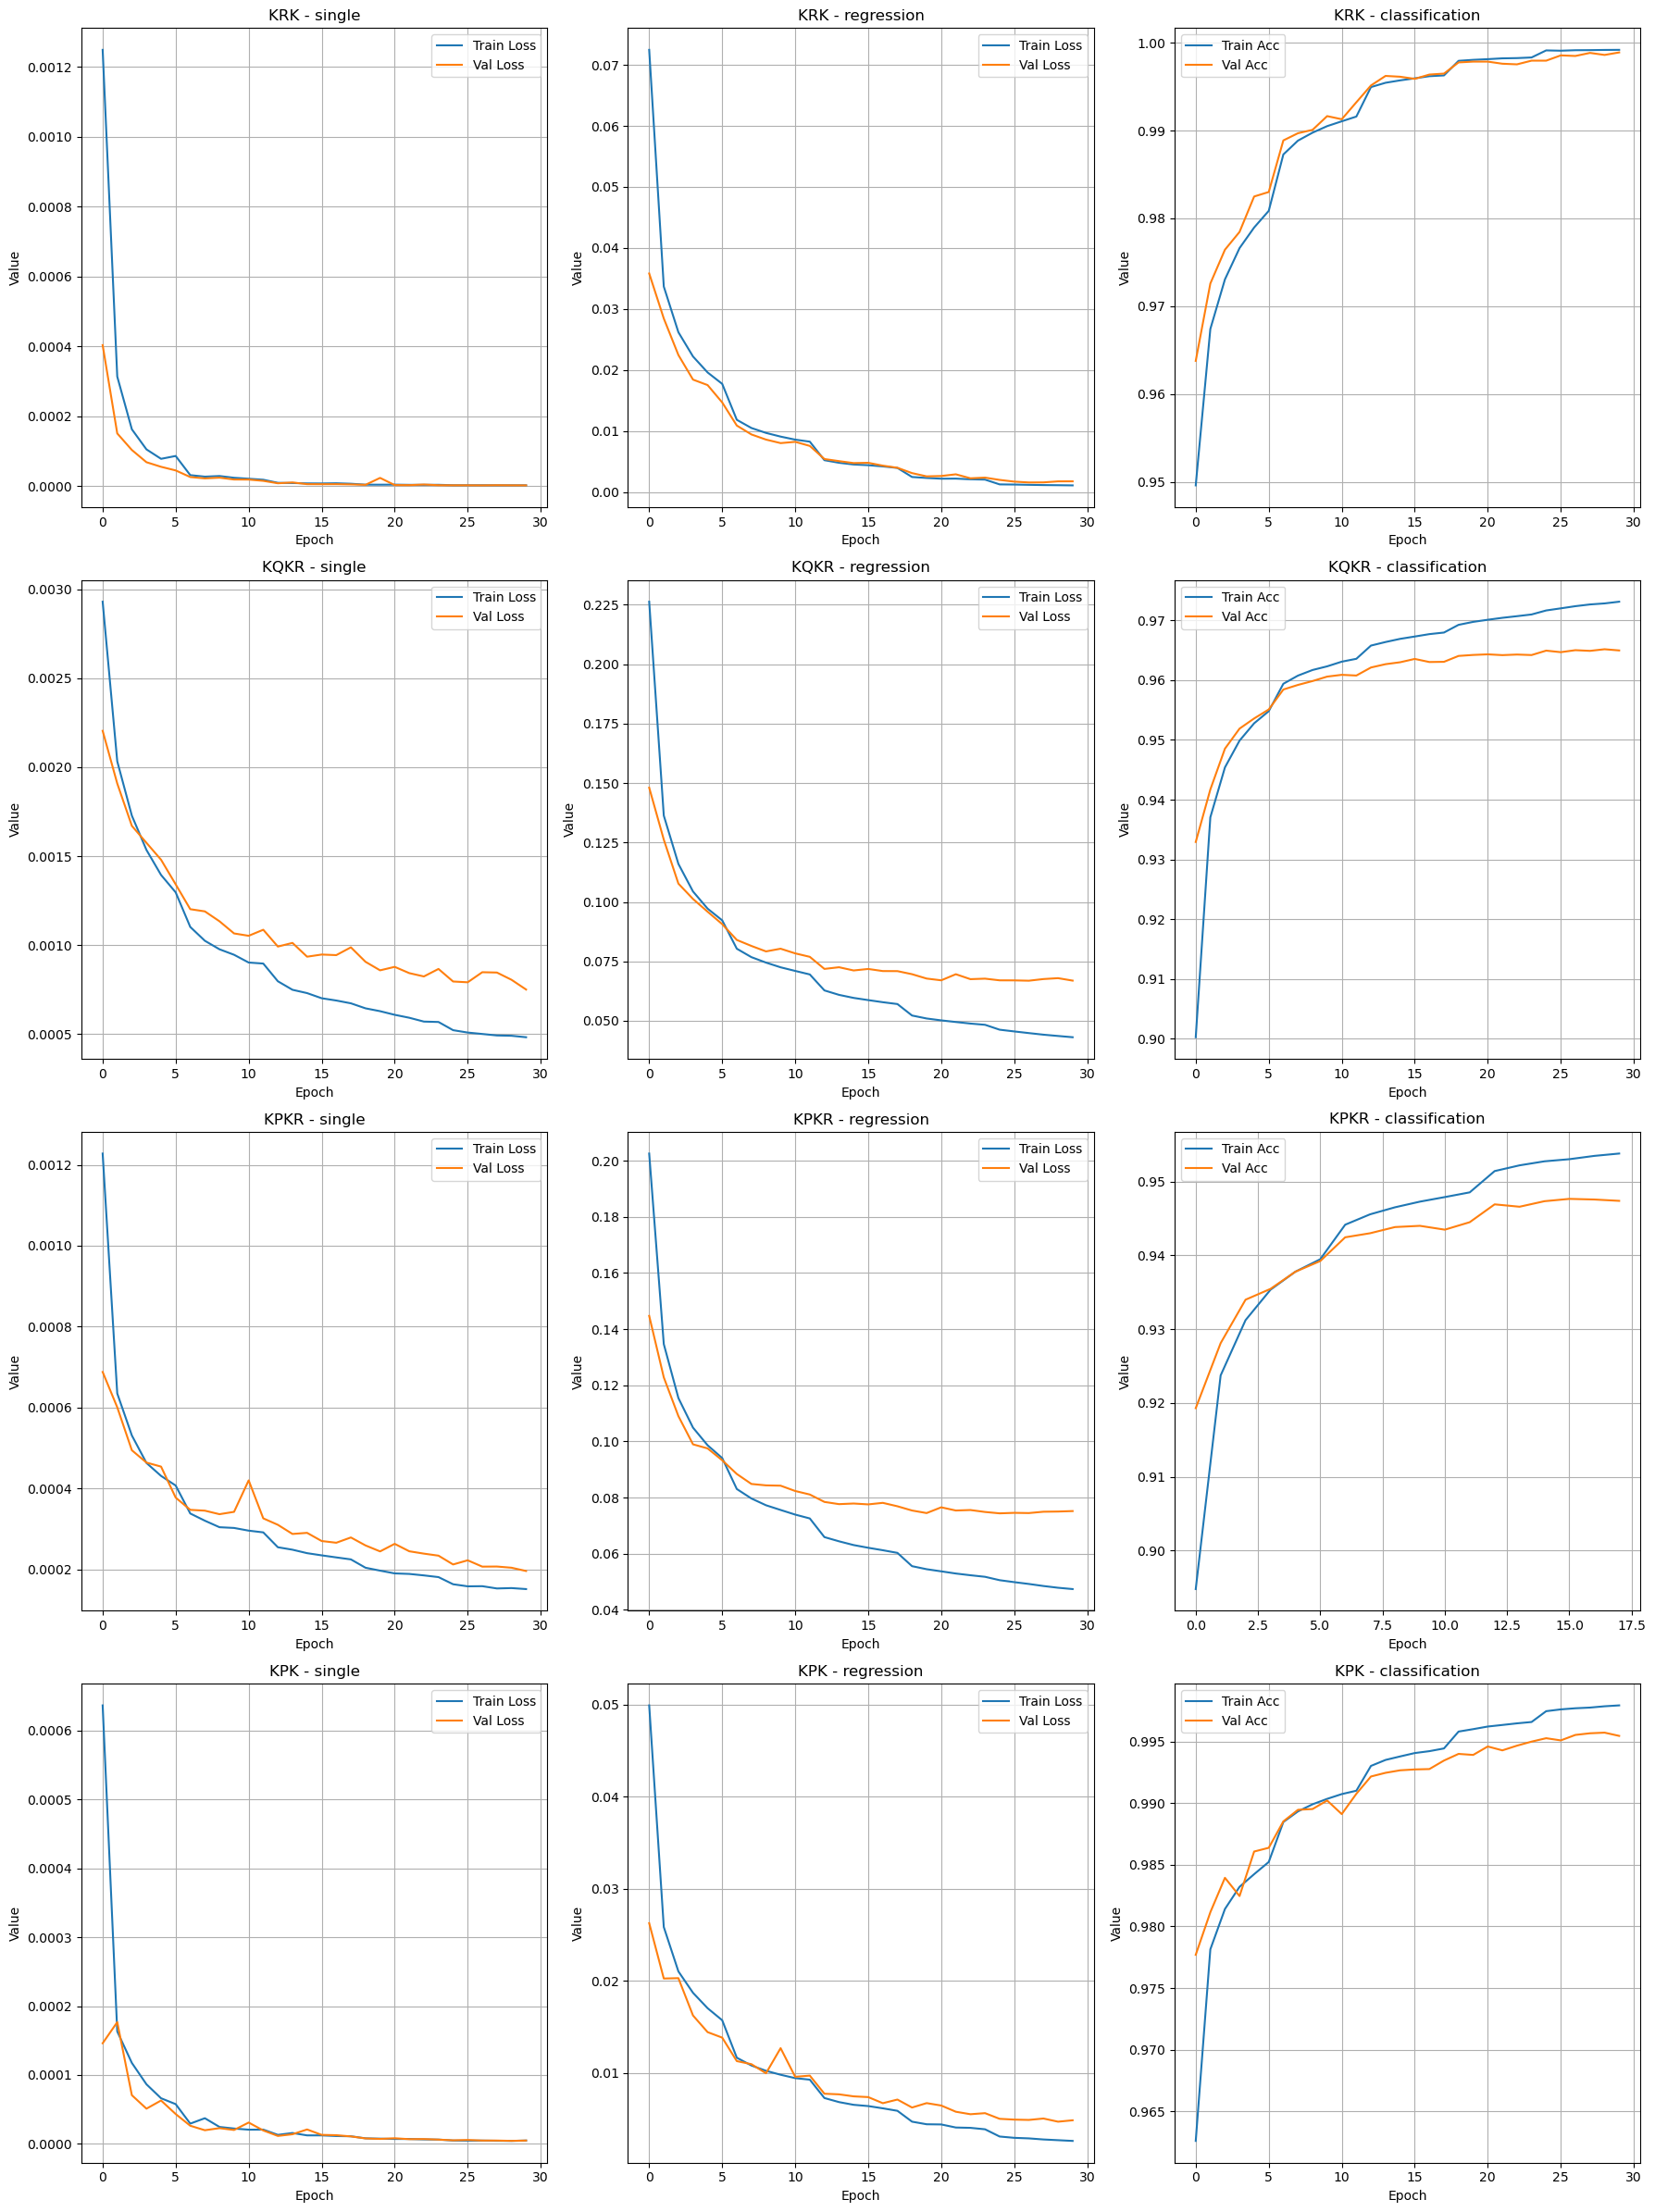

In [8]:
num_endgames = len(endgames)
num_models = len(model_types)

fig, axes = plt.subplots(num_endgames, num_models, figsize=(6 * num_models, 6 * num_endgames))

for row_idx, endgame in enumerate(endgames):
    for col_idx, model_type in enumerate(model_types):
        hist = histories[endgame][col_idx]
        ax = axes[row_idx, col_idx] if num_endgames > 1 else axes[col_idx]
        
        if 'accuracy' in hist:
            ax.plot(hist['accuracy'], label='Train Acc')
            ax.plot(hist['val_accuracy'], label='Val Acc')
        else:
            ax.plot(hist['loss'], label='Train Loss')
            ax.plot(hist['val_loss'], label='Val Loss')

        ax.set_title(f"{endgame} - {model_type}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

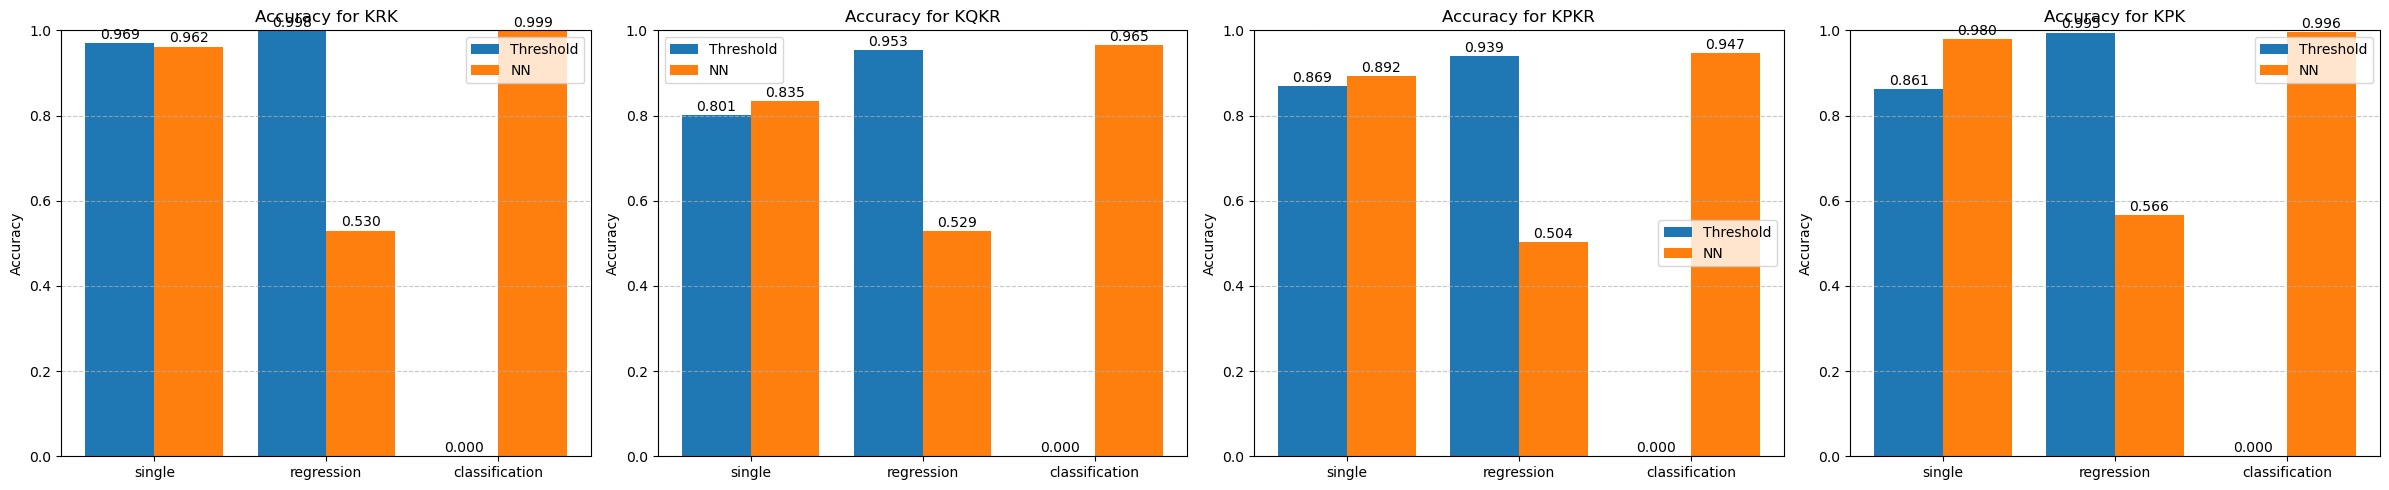

In [9]:
fig, axes = plt.subplots(1, len(endgames), figsize=(6 * len(endgames), 5))

if len(endgames) == 1:
    axes = [axes]  # ensure it's iterable

for idx, endgame in enumerate(endgames):
    ax = axes[idx]
    model_names = []
    accuracy_scores = []
    pro_accuracy_scores = []

    for i, model_type in enumerate(model_types):
        acc_pair = accuracies[endgame][model_type]
        model_names.append(model_type)
        if type(acc_pair) is tuple:
            pro_accuracy_scores.append(acc_pair[1])
            accuracy_scores.append(acc_pair[0])
        else:
            accuracy_scores.append(0)
            pro_accuracy_scores.append(acc_pair)
        

    x = range(len(model_names))
    ax.bar(x, accuracy_scores, width=0.4, label="Threshold", align='center')
    ax.bar([i + 0.4 for i in x], pro_accuracy_scores, width=0.4, label="NN", align='center')

    ax.set_xticks([i + 0.2 for i in x])
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1)
    ax.set_title(f"Accuracy for {endgame}")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(len(model_names)):
        ax.text(j, accuracy_scores[j] + 0.01, f'{accuracy_scores[j]:.3f}', ha='center')
        ax.text(j + 0.4, pro_accuracy_scores[j] + 0.01, f'{pro_accuracy_scores[j]:.3f}', ha='center')

plt.tight_layout()
plt.show()

Endgame: KRK
Class Equal Accuracy: 0.9907
Class Pos1 better Accuracy: 0.9995
Class Pos2 better Accuracy: 0.9994
Endgame: KQKR
Class Equal Accuracy: 0.8774
Class Pos1 better Accuracy: 0.9753
Class Pos2 better Accuracy: 0.9764
Endgame: KPKR
Class Equal Accuracy: 0.6640
Class Pos1 better Accuracy: 0.9721
Class Pos2 better Accuracy: 0.9707
Endgame: KPK
Class Equal Accuracy: 0.9844
Class Pos1 better Accuracy: 0.9970
Class Pos2 better Accuracy: 0.9977


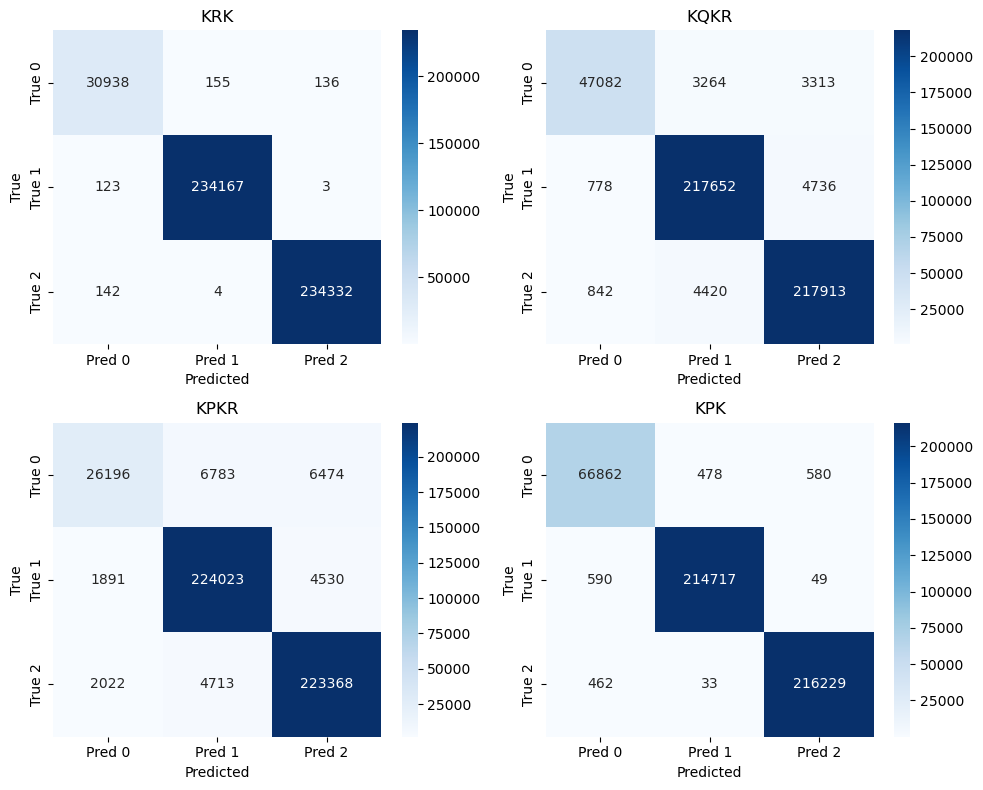

In [10]:
# Create a grid layout for subplots
n = len(cm)
cols = 2  # e.g. 3 plots per row
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

# Flatten axes for easy indexing
axes = axes.flatten()

class_labels = ["Equal", "Pos1 better", "Pos2 better"]

for i, (endgame_name, confusion_matrix) in enumerate(cm.items()):
    ax = axes[i]
    print(F"Endgame: {endgame_name}")
    # Print results with class labels
    for label, acc in zip(class_labels, (confusion_matrix.diagonal() / confusion_matrix.sum(axis=1))):
        print(f"Class {label} Accuracy: {acc:.4f}")
    # Plot heatmap in subplot
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Pred {j}" for j in range(3)],
        yticklabels=[f"True {j}" for j in range(3)],
        ax=ax
    )
    ax.set_title(f"{endgame_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
